# Cell 0. Original Model

- 기존 코드에서 best_overall_model.pth만 불러옴

c:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\utils.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(1)



🔹 No pre-trained model found. Starting training...

🔹 Training Original Model with Batch Size: 256
✅ Initial weights saved for batch 256!


c:\Users\ChoiSeongHyeon\anaconda3\envs\WinningT\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Batch 256, LR: 0.010000, Train Acc: 0.6078, Val Acc: 0.3205
✅ Best model saved (Batch 256) with val_acc 0.3205
Epoch 2: Batch 256, LR: 0.010000, Train Acc: 0.8316, Val Acc: 0.4069
✅ Best model saved (Batch 256) with val_acc 0.4069
Epoch 3: Batch 256, LR: 0.010000, Train Acc: 0.8759, Val Acc: 0.4856
✅ Best model saved (Batch 256) with val_acc 0.4856
Epoch 4: Batch 256, LR: 0.010000, Train Acc: 0.9003, Val Acc: 0.5777
✅ Best model saved (Batch 256) with val_acc 0.5777
Epoch 5: Batch 256, LR: 0.010000, Train Acc: 0.8834, Val Acc: 0.6699
✅ Best model saved (Batch 256) with val_acc 0.6699
Epoch 6: Batch 256, LR: 0.010000, Train Acc: 0.9038, Val Acc: 0.7236
✅ Best model saved (Batch 256) with val_acc 0.7236
Epoch 7: Batch 256, LR: 0.010000, Train Acc: 0.8980, Val Acc: 0.7620
✅ Best model saved (Batch 256) with val_acc 0.7620
Epoch 8: Batch 256, LR: 0.010000, Train Acc: 0.8916, Val Acc: 0.8061
✅ Best model saved (Batch 256) with val_acc 0.8061
Epoch 9: Batch 256, LR: 0.010000, Train 

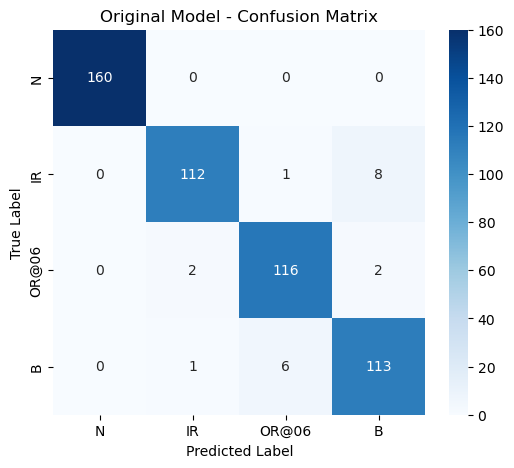

In [ ]:
import os
import torch
import pickle
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from model import WDCNN
from utils import (
    set_seed,

    # 데이터셋 및 학습 관련 함수
    CWRUDataset, train_original_model_with_batch_sizes, 
    fine_tune_unstructured, fine_tune_structured,
    plot_unstructured_pruning_results, plot_structured_pruning_results,
    
    # Pruning 적용 함수
    apply_sparse_training, apply_structured_pruning,
    remove_pruning_and_save_unstructured, remove_pruning_and_save_structured,

    # 평가 함수
    evaluate_classification, measure_inference_time, evaluate_test_performance_structured, evaluate_test_performance_unstructured,
    count_total_parameters, count_nonzero_parameters,

    # 변수 (경로)
    parameter_dir, original_path, unstructured_path, structured_path,
    load_unstructured_results, load_structured_results
)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 🔹 Dataset 로드
# ============================================================
train_dataset, val_dataset, test_dataset = (
    CWRUDataset("Train"), CWRUDataset("Validation"), CWRUDataset("Test")
)

# train_loader, val_loader는 어차피 train_original_model_with_batch_sizes 여기서 다시 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================================================
# 🔹 Original Model 학습 여부 체크 및 로드
# ============================================================
best_model_path = os.path.join(original_path, "best_overall_model.pth")

if not os.path.exists(best_model_path):
    print("\n🔹 No pre-trained model found. Starting training...")
    train_original_model_with_batch_sizes(train_dataset, val_dataset)
else:
    print("\n✅ Pre-trained model found. Skipping training.")

# ✅ Original Model 로드
original_model = WDCNN().to(device)
original_model.load_state_dict(torch.load(best_model_path, map_location=device))

# ✅ Original Model Classification Report & Confusion Matrix
evaluate_classification(original_model, test_loader, device, title="Original Model")


<Best Model 정보>
- Batch size : 
실험 조건
- lr
- optimizer
- weight decay
- lr scheduling (patience)
- early stop
- 

In [ ]:
# 재구현
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from model import WDCNN
from utils import (
    set_seed,
    CWRUDataset, train_original_model_with_batch_sizes, evaluate_classification,
    original_path, parameter_dir
)

# ✅ 재현성을 위한 시드 고정
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 🔹 Dataset 로드
# ============================================================
train_dataset, val_dataset, test_dataset = (
    CWRUDataset("Train"), CWRUDataset("Validation"), CWRUDataset("Test")
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ============================================================
# 🔹 초기 가중치 로드 및 모델 학습
# ============================================================
initial_weights_path = os.path.join(parameter_dir, "initial_weights_bs128.pth")
best_model_path = os.path.join(original_path, "best_overall_model.pth")

# ✅ 모델 초기화 후 초기 가중치 적용
if os.path.exists(initial_weights_path):
    print(f"\n🔹 Loading initial weights from: {initial_weights_path}")
    original_model = WDCNN().to(device)
    original_model.load_state_dict(torch.load(initial_weights_path, map_location=device))
else:
    raise FileNotFoundError(f"❌ Initial weights file not found at {initial_weights_path}")

# ✅ 초기 가중치로 학습 진행 (Batch Size = 256 고정)
print("\n🚀 Starting training with initial weights (Batch Size: 256)...")
train_original_model_with_batch_sizes(train_dataset, val_dataset, batch_sizes=[128])

# ✅ Original Model 로드
original_model = WDCNN().to(device)
original_model.load_state_dict(torch.load(best_model_path, map_location=device))

evaluate_classification(original_model, test_loader, device, title="Original Model")

# Cell 1. Unstructured Pruning

## Cell 1.1 Fine-Tuning

In [2]:
# ============================================================
# 🔹 Unstructured Pruning Fine-Tuning 수행 (1번만)
# ============================================================
pruning_ratios = [0.2, 0.4, 0.6, 0.8]

# 🔹 저장된 Fine-Tuning 결과가 있는지 확인
experiment_results_path = os.path.join(unstructured_path, "experiment_results.pkl")
experiment_results = None

if os.path.exists(experiment_results_path):
    with open(experiment_results_path, "rb") as f:
        experiment_results = pickle.load(f)
    print("\n✅ 기존 Fine-Tuning 결과를 불러왔습니다. 학습을 건너뜁니다.")
else:
    print("\n🔹 Starting Unstructured Pruning Fine-Tuning...")
    experiment_results = fine_tune_unstructured(pruning_ratios, train_loader, val_loader, num_epochs=100)
    print("\n✅ Unstructured Pruning Fine-Tuning Completed!")



✅ 기존 Fine-Tuning 결과를 불러왔습니다. 학습을 건너뜁니다.


## Cell 1.2 Graph


🔹 Plotting Unstructured Pruning Validation Accuracy Graph...


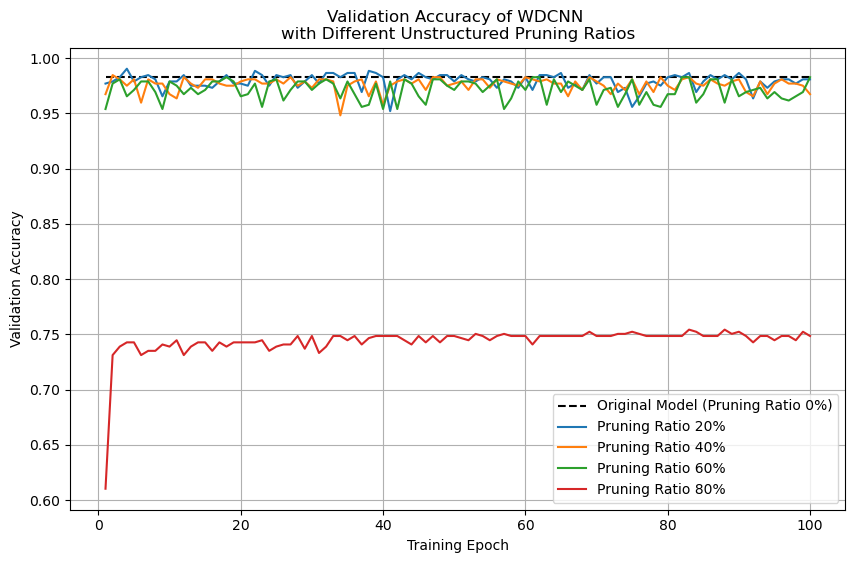


✅ Graph Generated!


In [3]:
# ============================================================
# 🔹 Validation Accuracy 그래프 출력 (Original Model 포함)
# ============================================================
print("\n🔹 Plotting Unstructured Pruning Validation Accuracy Graph...")
plot_unstructured_pruning_results(experiment_results, num_epochs=100, val_loader=val_loader, include_original=True)
print("\n✅ Graph Generated!")


## Cell 1.3 Table

In [ ]:
## ✅ Cell 1.3: Test Performance Evaluation (Inference 포함 - Unstructured)
print("\n🔹 Final Test Performance Evaluation for Unstructured Pruning (Including Inference Time)...")
evaluate_test_performance_unstructured(original_model, test_loader, device, experiment_results, unstructured_path)


🔹 Final Test Performance Evaluation for Unstructured Pruning (Including Inference Time)...


,Pruning Ratio,Number of Non-Zero Params,Inference Time (s),Test Accuracy
0,0.0,41404,0.000919,0.988484
1,0.2,33281,0.000858,0.988484
2,0.4,25161,0.000824,0.986564
3,0.6,17039,0.000817,0.967370
4,0.8,8919,0.000855,0.754319


# Cell 2. Structured Pruning

## Cell 2.1

In [ ]:
# ============================================================
# 🔹 Structured Pruning Fine-Tuning 수행 (1번만)
# ============================================================
structured_pruning_ratios = [0.2, 0.4, 0.6, 0.8]

# 🔹 저장된 Fine-Tuning 결과가 있는지 확인
structured_experiment_results_path = os.path.join(structured_path, "structured_experiment_results.pkl")
structured_experiment_results = None

if os.path.exists(structured_experiment_results_path):
    with open(structured_experiment_results_path, "rb") as f:
        structured_experiment_results = pickle.load(f)
    print("\n✅ 기존 Structured Fine-Tuning 결과를 불러왔습니다. 학습을 건너뜁니다.")
else:
    print("\n🔹 Starting Structured Pruning Fine-Tuning...")
    structured_experiment_results = fine_tune_structured(structured_pruning_ratios, train_loader, val_loader, num_epochs=100)
    print("\n✅ Structured Pruning Fine-Tuning Completed!")



✅ 기존 Structured Fine-Tuning 결과를 불러왔습니다. 학습을 건너뜁니다.


## Cell 2.2


🔹 Plotting Structured Pruning Validation Accuracy Graph...

🔹 Calculating Original Model Validation Accuracy for Graph...


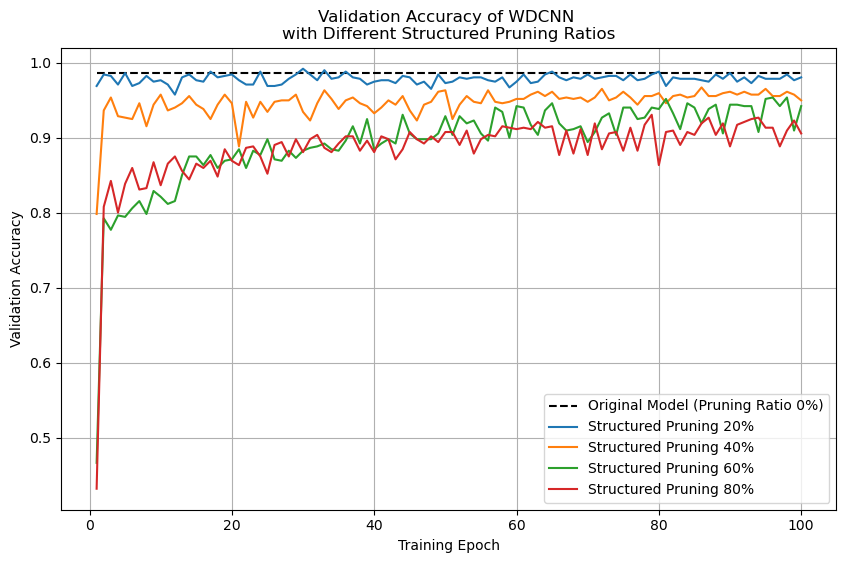


✅ Graph Generated!


In [ ]:
## ✅ Cell 2.2: Validation Accuracy 그래프 출력
print("\n🔹 Plotting Structured Pruning Validation Accuracy Graph...")
plot_structured_pruning_results(structured_experiment_results, num_epochs=100, val_loader=val_loader, include_original=True)
print("\n✅ Graph Generated!")

## Cell 2.3

In [ ]:
## ✅ Cell 2.3: Test Performance Evaluation (Inference 포함 - Structured)
print("\n🔹 Final Test Performance Evaluation for Structured Pruning (Including Inference Time)...")
evaluate_test_performance_structured(original_model, test_loader, device, structured_experiment_results, structured_path)


🔹 Final Test Performance Evaluation for Structured Pruning (Including Inference Time)...


,Pruning Ratio,Number of Non-Zero Params,Inference Time (s),Test Accuracy
0,0.0,41404,0.000789,0.988484
1,0.2,34684,0.000849,0.980806
2,0.4,27916,0.000874,0.961612
3,0.6,21612,0.000962,0.928983
4,0.8,14844,0.000824,0.915547


# Cell 3. Iterative Magnitude Pruning

## 실험 전체적인 개요
[Cell 3.1 20%씩 10회 Pruning 하기]
- 각 Pruning Ratio별 Test Acc -> Table로 나중에 제시할 것
- Validation Acc -> Graph

## Cell 3.1 20%씩 10회 Pruning하여, 각 Pruning Ratio별 Validation Acc를 그래프로 그리기!
- 또한 해당 모델들을 저장할 것!

### Cell 3.1.1 Original Model을 20%씩 Iterative Magnitude Pruning 할거야.
그렇게 되면 Percent of Weight remaining은 80, 64, 51.2, 41, 32.8, 26.2, 21, 16.8, 13.4, 10.7 (%)가 되겠지.  
Unstructured Pruning을 하는 거고, 과정은 다음과 같아.  
1. C:\Users\ChoiSeongHyeon\Desktop\WinningT\Winning Ticket\MyWinningTicket\CWRU\Parameters\Original에 있는 best_overall_model.pth에서 20%를 Unstructured Pruning함.  
2. Pruning된 모델 구조에서 initial_weights_bs_

## Cell 3.2 그래프 상에서 특정 Pruning Ratio를 선택하고, 해당 모델로 Initialization하기!

## Cell 3.3 Test ACC 비교하기!